## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 6 - Construct Portfolios**

In [82]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [83]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'd:\\self_learning_python\\self_learning\\My_Strategies_CTA\\stats.py'>

这一块的代码每次跑的都不一样，应该是没设置什么random seed一类的

In [84]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [85]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [86]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "201901"
test_sample = np.array(all_dates) > "201901"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [87]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [88]:
import random
def get_chosen_strategy(product_list, result_dire, save_name, min_num=20, min_pnl=2):
    random.seed(100)
    os.makedirs(HEAD_PATH+"\\"+save_name, exist_ok=True)
    for product in product_list:
        chosen_strategy = dict()
        pnl_mat = None
        spread = product_info[product]["spread"]
        min_pnl = min_pnl*spread
        train_stat = None
        test_stat = None
        for y in signal_list:
            result = load(HEAD_PATH+"\\"+result_dire+"\\"+product+"."+y+".pkl")["reverse.signal.stat"]
            if "train.stat" in result.keys():
                train_stat = result["train.stat"]
                test_stat = result["test.stat"]
                avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean()
                avg_pnl.fillna(0, inplace=True)
                good_strat = (avg_pnl>=min_pnl) & (train_stat["final.result"]["avg.pnl"]>=min_pnl)  & (train_stat["final.result"]["num"]>=min_num)
                if sum(good_strat)==0:
                    continue
                elif sum(good_strat)<=5:
                    chosen_strategy[y] = good_strat
                elif sum(good_strat)>5:
                    chosen =np.random.choice(sum(good_strat), 5, replace=False)
                    good_strat = np.array(np.where(good_strat))[0,chosen]
                    chosen_strategy[y] = good_strat
                if pnl_mat is None:
                    pnl_mat = train_stat["daily.ret"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, train_stat["daily.ret"].loc[:, good_strat].values))
            save((chosen_strategy, pnl_mat), HEAD_PATH+"\\"+save_name+"\\"+product+".pkl")

In [89]:
def get_test_mat(pnl_mat, signal_name):
    if not (signal_name in chosen_strategy):
        return pnl_mat
    result = load(HEAD_PATH+"\\"+result_dire+"\\"+product+"."+signal_name+".pkl")["reverse.signal.stat"]
    train_stat = result["test.stat"]
    test_stat = result["test.stat"]
    
    avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean()
    avg_pnl.fillna(0, inplace=True)
    good_strat = chosen_strategy[signal_name]
    if sum(good_strat)==0:
        return pnl_mat
    elif pnl_mat is None:
        return test_stat["daily.ret"].loc[:, good_strat].values
    else:
        return np.hstack((pnl_mat, test_stat["daily.ret"].loc[:, good_strat].values))

In [90]:
get_chosen_strategy(product_list, "signal_result_atr", "chosen_strategy_atr", min_num=20, min_pnl=2)

In [91]:
all_test_mat=dict([])
result_dire = "signal_result_atr"
save_name = "chosen_strategy_atr"
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"\\"+save_name+"\\"+product+".pkl")
    test_mat = functools.reduce(get_test_mat, signal_list, None)
    all_test_mat[product] = test_mat

rb train sharpe:  1.715338748266945 test sharpe:  0.7426818390907559
hc train sharpe:  1.4585210827548745 test sharpe:  -0.45872299773329434
i train sharpe:  1.2560795171219976 test sharpe:  0.5606200199711185
j train sharpe:  0.7063997228812076 test sharpe:  -0.06519824609091754
jm train sharpe:  1.0114220615421514 test sharpe:  -0.4907559394490101
portfolio train sharpe:  2.4373384711713038 test sharpe:  -0.17831021879210313


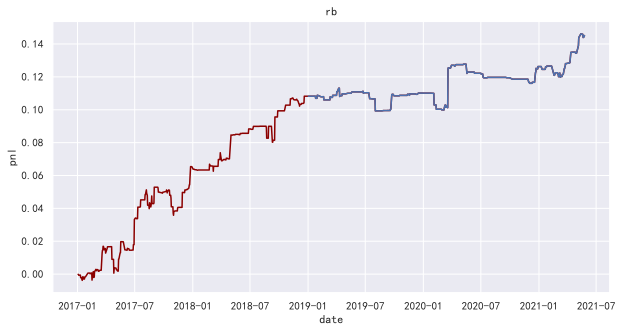

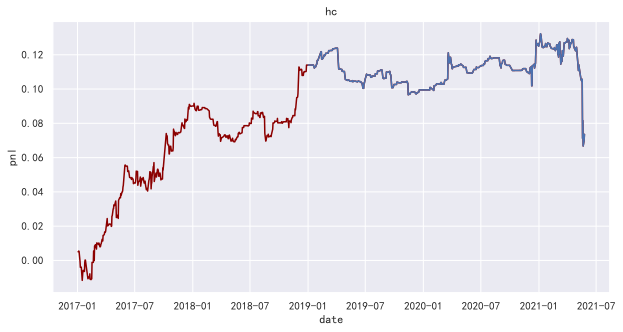

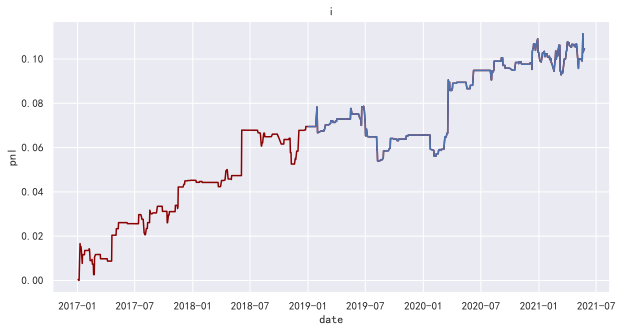

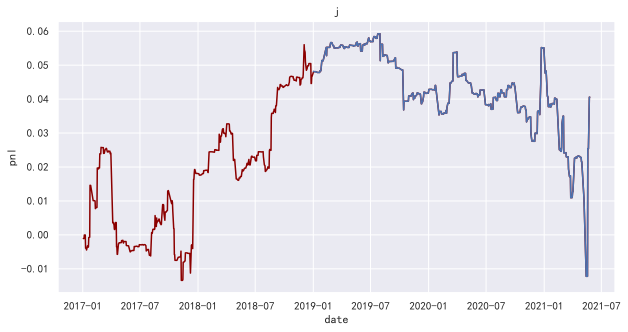

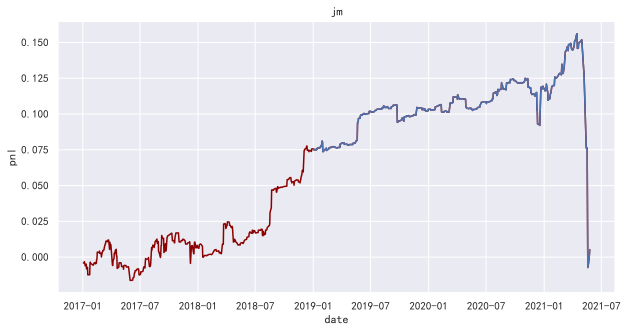

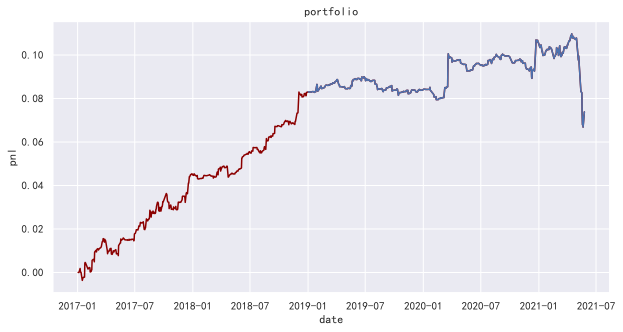

In [92]:
i = 0
result_dire = "signal_result_atr"
save_name = "chosen_strategy_atr"
n_product = len(product_list)
portfolio = np.zeros((n_days, n_product))
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"\\"+save_name+"\\"+product+".pkl")
    avg_train_pnl = pnl_mat.mean(axis=1)
    avg_test_pnl = all_test_mat[product].mean(axis=1)
    all_pnl = np.append(avg_train_pnl, avg_test_pnl)
    #all_pnl = all_pnl/np.std(avg_train_pnl)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.plot(format_dates, all_pnl.cumsum(), color="darkred")
    plt.plot(format_dates[test_sample], all_pnl.cumsum()[test_sample], color="b")
    #portfolio = portfolio+all_pnl/len(product_list)
    portfolio[:,i-1] = all_pnl
    print(product, "train sharpe: ", sharpe(avg_train_pnl),"test sharpe: ", sharpe(avg_test_pnl))

i = i+1
plt.figure(i, figsize=(10, 5))
plt.title("portfolio")
plt.xlabel("date")
plt.ylabel("pnl")
avg_portfolio = portfolio.mean(axis=1)
plt.plot(format_dates, avg_portfolio.cumsum(), color="darkred")
plt.plot(format_dates[test_sample], avg_portfolio.cumsum()[test_sample], color="b")
print("portfolio", "train sharpe: ", sharpe(avg_portfolio[train_sample]),"test sharpe: ", sharpe(avg_portfolio[test_sample]))


In [93]:
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》

In [94]:
pnl_mat = portfolio[train_sample,:]
mean_return = pnl_mat.mean(axis=0)

In [95]:
cov_return = np.cov(pnl_mat, rowvar=False)
n_point = 30
n_strat = pnl_mat.shape[1]
m_grid = np.linspace(min(mean_return), max(mean_return), n_point)
m_grid

array([9.58701656e-05, 1.00635219e-04, 1.05400273e-04, 1.10165327e-04,
       1.14930381e-04, 1.19695435e-04, 1.24460488e-04, 1.29225542e-04,
       1.33990596e-04, 1.38755650e-04, 1.43520703e-04, 1.48285757e-04,
       1.53050811e-04, 1.57815865e-04, 1.62580919e-04, 1.67345972e-04,
       1.72111026e-04, 1.76876080e-04, 1.81641134e-04, 1.86406188e-04,
       1.91171241e-04, 1.95936295e-04, 2.00701349e-04, 2.05466403e-04,
       2.10231457e-04, 2.14996510e-04, 2.19761564e-04, 2.24526618e-04,
       2.29291672e-04, 2.34056726e-04])

In [96]:
import scipy
E,V = scipy.linalg.eigh(cov_return)
np.all(E > 0)

True

In [97]:
cov_grid = np.repeat(np.nan, n_point)
weight_grid = np.zeros((n_strat, n_point))

In [98]:
s_inv = np.linalg.inv(cov_return)
s_inv

array([[245225.46048732,  26294.43573737,   7957.98466599,
         17260.10762609,  -3144.94042668],
       [ 26294.43573737, 167122.50720793, -27247.95080407,
        -37697.26122784,   9946.41718609],
       [  7957.98466599, -27247.95080407, 318371.64670946,
        -21147.72823613,  -1200.2814048 ],
       [ 17260.10762609, -37697.26122784, -21147.72823613,
        271963.05368632, -94305.14337636],
       [ -3144.94042668,   9946.41718609,  -1200.2814048 ,
        -94305.14337636, 202764.57762247]])

In [99]:
for i in range(1, n_point-1):
    w = get_weight(mean_return, cov_return, m_grid[i])
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w
## here we don't use the first value and last value to avoid scientific computing error

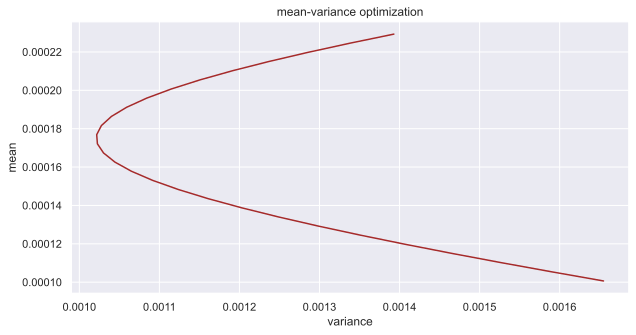

In [100]:
sns.set_theme()
plt.figure(1, figsize=(10, 5))
plt.title("mean-variance optimization")
plt.xlabel("variance")
plt.ylabel("mean")
plt.plot(cov_grid, m_grid, color="brown")

<BarContainer object of 5 artists>

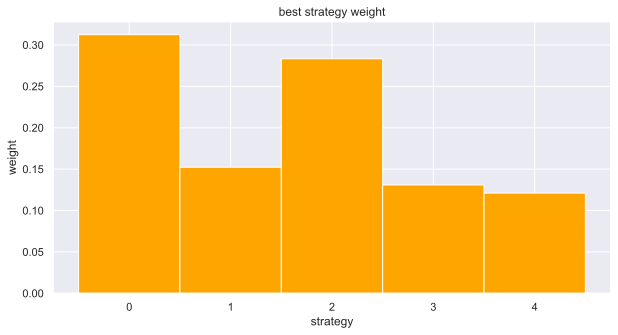

In [101]:
best_index = np.nanargmin(cov_grid)
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
plt.figure(1, figsize=(10, 5))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(best_weight.index.values, best_weight.values, width=1, color="orange")

In [102]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return)).T
n_strat

5

In [103]:
# https://pypi.org/project/quadprog/
# pip install quadprog
# need to download visual studio before running
import quadprog as qp

In [104]:
m_grid[best_index]

0.00017687608002729636

In [105]:
sol = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.array([1, m_grid[best_index]]), meq=2)
sol[0]

array([0.31240777, 0.15231155, 0.28330048, 0.13090899, 0.12107121])

In [106]:
sum(abs(sol[0] - best_weight) > 0.00001)

0

In [107]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)))).T
A_mat.shape

(5, 7)

In [108]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.zeros(n_strat))), meq=2)
sol_nneg[0]

array([0.31240777, 0.15231155, 0.28330048, 0.13090899, 0.12107121])

In [109]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.repeat(1e-5, n_strat))), meq=2)
sol_nneg[0]

array([0.31240777, 0.15231155, 0.28330048, 0.13090899, 0.12107121])

In [110]:
1/n_strat

0.2

In [111]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)), -np.diag(np.repeat(1, n_strat)))).T
cov_grid = np.repeat(np.nan, n_point)
for i in range(1, n_point-1):
    try:
        sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, 
                               b=np.hstack((1, m_grid[i], np.repeat(1e-5, n_strat), np.repeat(-0.3, n_strat))), meq=2)
    except ValueError:
        continue
    w = sol_nneg[0]
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w

In [112]:
best_index = np.nanargmin(cov_grid)
weight_grid[:, best_index]

array([0.3       , 0.15969509, 0.28785584, 0.12575318, 0.1266959 ])

<BarContainer object of 5 artists>

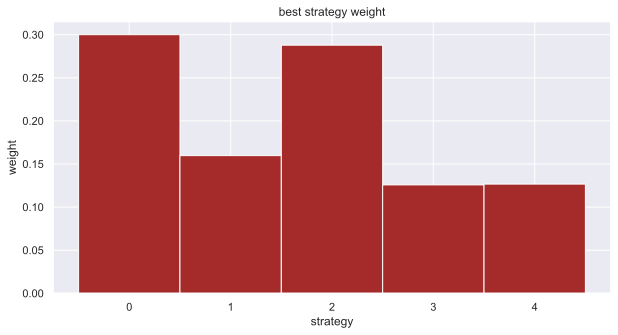

In [113]:
plt.figure(1, figsize=(10, 5))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(np.linspace(0, len(weight_grid)-1, len(weight_grid)), weight_grid[:, best_index], width=1, color="brown")

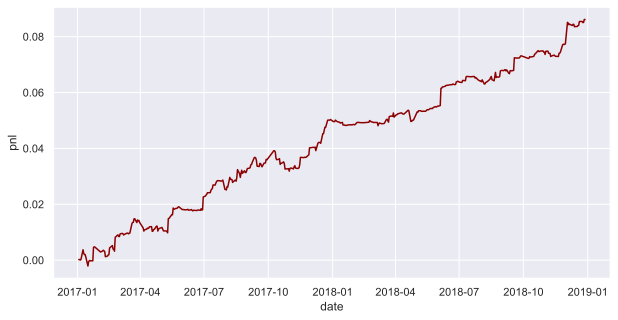

In [114]:
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
best_weight[best_weight<1.1e-5] = 0
train_pnl = np.dot(pnl_mat, best_weight)
train_pnl = pd.Series(train_pnl)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pnl.cumsum(), color="darkred")

In [115]:
sharpe(train_pnl)

2.7355441517360948

In [116]:
test_mat = portfolio[test_sample,:]
test_pnl = np.dot(test_mat, best_weight)

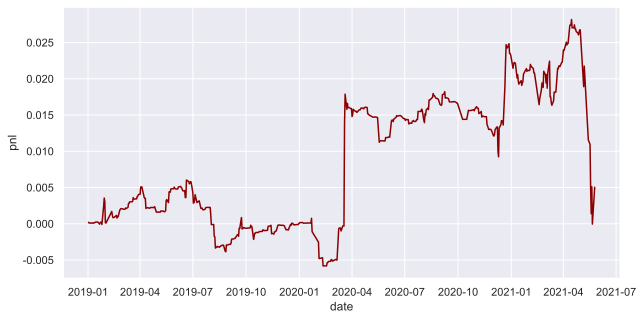

In [117]:
test_pnl = np.dot(test_mat, best_weight)
test_pnl = pd.Series(test_pnl)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="darkred")

In [118]:
sharpe(test_pnl)

0.11537768184782529

In [119]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

In [120]:
from scipy.optimize import minimize
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)
    
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

In [121]:
parity_weight = risk_parity(pnl_mat)
parity_weight = pd.Series(parity_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 91
         Function evaluations: 163


<BarContainer object of 5 artists>

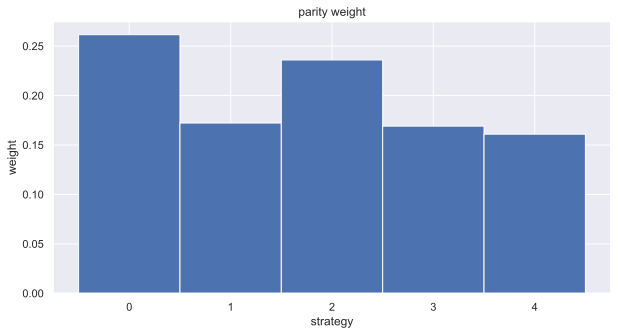

In [122]:
plt.figure(1, figsize=(10, 5))
plt.title("parity weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(parity_weight.index, parity_weight.values, width=1, color="b")

In [123]:
sum(parity_weight<0)

0

In [124]:
train_parity = np.dot(pnl_mat, parity_weight)
train_parity = pd.Series(train_parity)

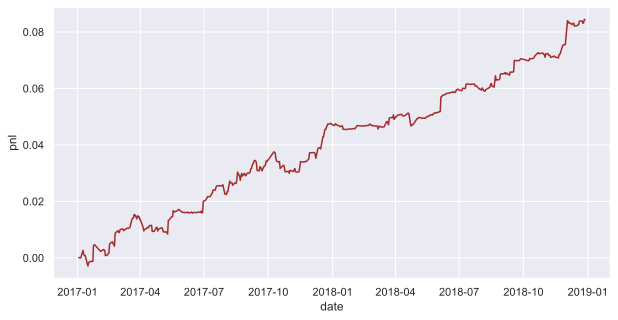

In [125]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_parity.cumsum(), color='brown')

In [126]:
sharpe(train_parity)

2.632464884997343

In [127]:
test_parity = np.dot(test_mat, parity_weight)
test_parity = pd.Series(test_parity)

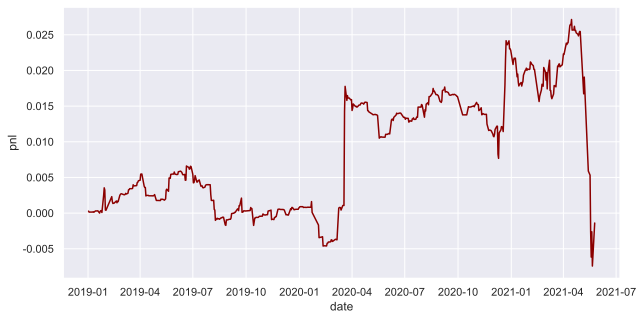

In [128]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_parity.cumsum(), color='darkred')

In [129]:
sharpe(test_parity)

-0.03035329989928724

In [130]:
diagonal_weight = risk_parity(pnl_mat, only_diag=True)
diagonal_weight = pd.Series(diagonal_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 98
         Function evaluations: 172


<BarContainer object of 5 artists>

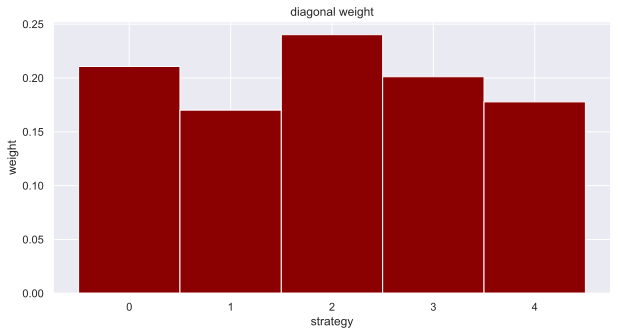

In [131]:
plt.figure(1, figsize=(10, 5))
plt.title("diagonal weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(diagonal_weight.index, diagonal_weight.values, width=1, color="darkred")

In [132]:
sum(parity_weight<0)

0

In [133]:
train_diagonal = np.dot(pnl_mat, diagonal_weight)
train_diagonal = pd.Series(train_diagonal)

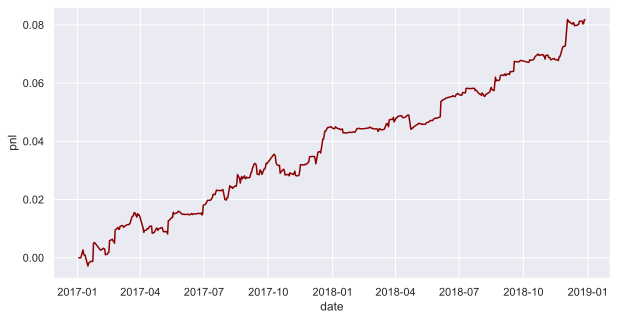

In [134]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_diagonal.cumsum(), color="darkred")

In [135]:
sharpe(train_diagonal)

2.4738656166328

In [136]:
test_diagonal = np.dot(test_mat, diagonal_weight)
test_diagonal = pd.Series(test_diagonal)

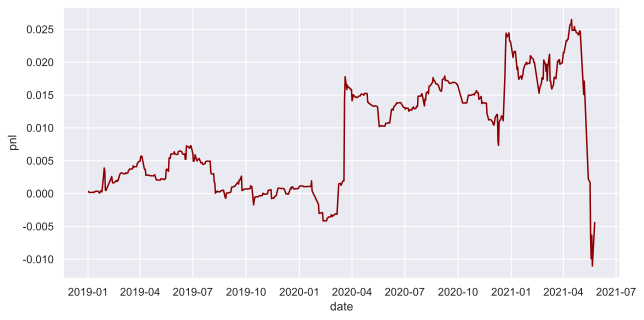

In [137]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_diagonal.cumsum(), color="darkred")

In [138]:
sharpe(test_diagonal)


-0.09184152781712028

In [139]:
sharpe_mat = np.apply_along_axis(sharpe, 0, pnl_mat)
sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
sharpe_weight = pd.Series(sharpe_weight)

In [140]:
train_sharpe = np.dot(pnl_mat, sharpe_weight)
train_sharpe = pd.Series(train_sharpe)

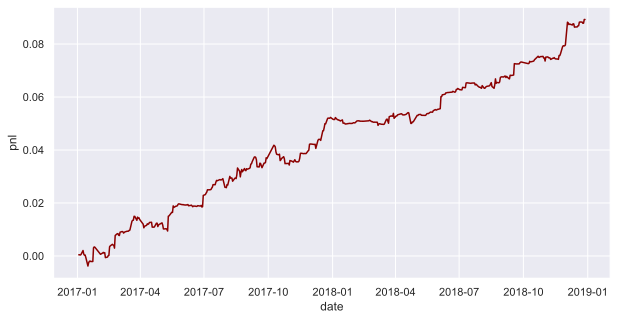

In [141]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_sharpe.cumsum(), color="darkred")

In [142]:
sharpe(train_sharpe)


2.733032926114097

In [143]:
test_sharpe = np.dot(test_mat, sharpe_weight)
test_sharpe = pd.Series(test_sharpe)

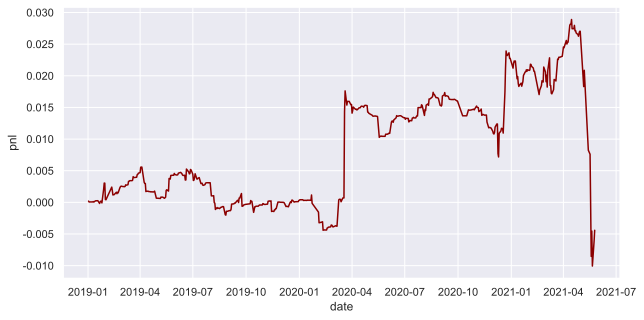

In [144]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_sharpe.cumsum(), color="darkred")

In [145]:
sharpe(test_sharpe)

-0.09294697455600487

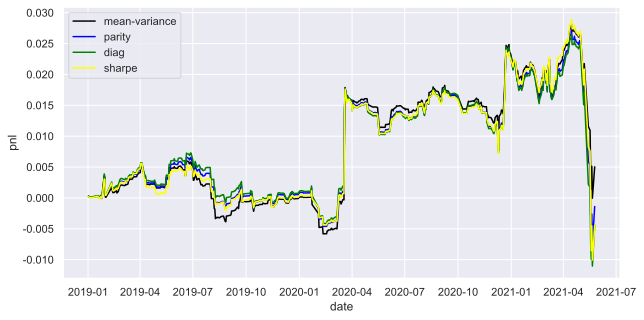

In [146]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
#avg_plot, = plt.plot(format_dates[test_sample], avg_portfolio.mean(axis=1).cumsum(), color="red", label="average");
mean_plot, = plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="black", label="mean-variance")
parity_plot, = plt.plot(format_dates[test_sample], test_parity.cumsum(), color="blue", label="parity")
diag_plot, = plt.plot(format_dates[test_sample], test_diagonal.cumsum(), color="green", label="diag")
sharpe_plot, = plt.plot(format_dates[test_sample], test_sharpe.cumsum(), color="yellow", label="sharpe")
plt.legend(handles=[mean_plot,parity_plot, diag_plot, sharpe_plot])

In [147]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(pnl_mat)
rotation = pca.components_.transpose()
rotation

array([[-0.1912794 , -0.21262565,  0.95082938,  0.08417709,  0.0839061 ],
       [ 0.54961266,  0.73558413,  0.30526636, -0.2223219 , -0.11927835],
       [ 0.14788849,  0.10424511,  0.00451528,  0.91294341, -0.36575387],
       [ 0.55067592, -0.20269396, -0.02420715,  0.24332061,  0.77193282],
       [ 0.57984751, -0.60146025,  0.04614722, -0.22542538, -0.49907541]])

In [148]:
train_pca = np.mean(np.matmul(pnl_mat,rotation), axis=1)

In [149]:
sharpe(train_pca)

1.8760287778959064

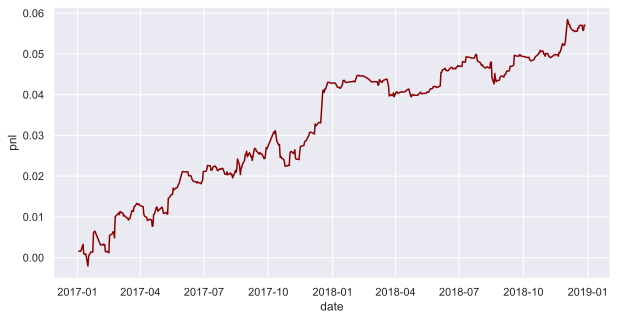

In [150]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pca.cumsum(), color="darkred")

In [151]:
test_pca = np.mean(np.matmul(test_mat,rotation), axis=1)

In [152]:
sharpe(test_pca)

0.23717966129528123

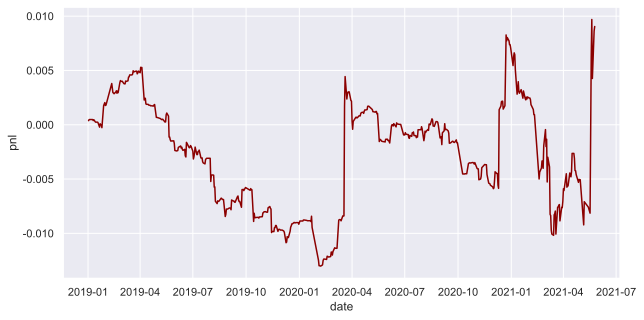

In [153]:
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pca.cumsum(), color='darkred')